# Разработка решения, позволяющее оптимизировать управление персоналом, для HR-аналитики компании «Работа с заботой».

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.

У нас будет несколько задач: Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

# Задача 1

## Загрузка данных

In [ ]:
!pip install -U scikit-learn -q
!pip install phik -q

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn import model_selection, metrics
from sklearn.metrics import make_scorer
import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

In [ ]:
train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
train_job_satisfaction_rate.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


In [ ]:
test_features = pd.read_csv('/datasets/test_features.csv')
test_features.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


In [ ]:
test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
test_target_job_satisfaction_rate.head(10)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


## Предобработка данных

In [ ]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [ ]:
train_job_satisfaction_rate.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [ ]:
train_job_satisfaction_rate.duplicated().sum()

0

In [ ]:
duplicate_id = train_job_satisfaction_rate[train_job_satisfaction_rate.duplicated(['id'])]

print(duplicate_id)

Empty DataFrame
Columns: [id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary, job_satisfaction_rate]
Index: []


In [ ]:
for col in train_job_satisfaction_rate.iloc[:, 1:8]:
    print(train_job_satisfaction_rate[col].unique ())

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']
[ 2  1  4  7  9  6  3 10  8  5]
['no' 'yes']
['no' 'yes']
[1 5 2 3 4]


In [ ]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [ ]:

test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [ ]:

duplicate_id = test_features[test_features.duplicated(['id'])]
print(duplicate_id)

Empty DataFrame
Columns: [id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary]
Index: []


In [ ]:

duplicate_id = test_features[test_features.duplicated(['id'])]
print(duplicate_id)

Empty DataFrame
Columns: [id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary]
Index: []


In [ ]:

test_features['dept'] = test_features['dept'].replace(' ', np.nan)
test_features['workload'] = test_features['workload'].replace(' ', np.nan)
for col in test_features.iloc[:, 1:8]:
    print(test_features[col].unique ())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' nan]
[ 2  1  5  6  3  9  7  4  8 10]
['no' 'yes']
['no' 'yes']
[5 4 3 1 2]


In [ ]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [ ]:
test_target_job_satisfaction_rate.duplicated().sum()

0

In [ ]:

duplicate_id = test_target_job_satisfaction_rate[test_target_job_satisfaction_rate.duplicated(['id'])]
print(duplicate_id)

Empty DataFrame
Columns: [id, job_satisfaction_rate]
Index: []


Провели предобработку полученных данных. Дубликаты не обнаружены. Выявлены пропуски и пробелы в данных. Проведем замену пробелов ' ' на np.nan пропуск. Проведем в дальнейшем заполнение пропусков в пайплайне при обучении модели с использованием SimpleImputer в категориальных признаках на самое распростроненное значение.

## Исследовательский анализ данных

In [ ]:
def grafic(freim):
    # Исключаем столбцы, которые не нужно визуализировать
    num_cols = freim.select_dtypes(include=["float64", "int64"]).columns
    exclude_cols = ['id', 'ID', 'customer_id']  # Добавьте сюда другие бесполезные столбцы
    num_cols = [col for col in num_cols if col.lower() not in [x.lower() for x in exclude_cols]]

    for col in num_cols:
        unique_vals = freim[col].nunique()

        # Для дискретных признаков с небольшим числом уникальных значений
        if unique_vals <= 15:
            plt.figure(figsize=(8, 4))
            sns.countplot(x=freim[col])
            plt.title(f"Распределение {col} (дискретный признак)")
            plt.xlabel(col)
            plt.ylabel("Количество")
            plt.show()

            # Боксплот для дискретных признаков (если значений достаточно)
            if unique_vals > 2:
                plt.figure(figsize=(6, 4))
                sns.boxplot(x=freim[col])
                plt.title(f"Боксплот {col}")
                plt.show()

        # Для непрерывных признаков
        else:
            plt.figure(figsize=(6, 4))
            sns.histplot(freim[col], kde=True, bins=20)
            plt.title(f"Распределение {col} (непрерывный признак)")
            plt.xlabel(col)
            plt.ylabel("Частота")
            plt.show()

            plt.figure(figsize=(6, 4))
            sns.boxplot(x=freim[col])
            plt.title(f"Боксплот {col}")
            plt.show()



def grafic_categor(freim):
    categorical = freim.select_dtypes(include=['object', 'category', 'bool']).columns
    for column in categorical:
        plt.figure(figsize=(10, 4))

    # Столбчатая диаграмма
        sns.countplot(x=freim[column])
        plt.title(f'Частота категорий в {column}')
        plt.xticks(rotation=45)
        plt.show()

    # Круговая диаграмма (если категорий < 7)
        if freim[column].nunique() <= 7:
            freim[column].value_counts().plot.pie(autopct='%1.1f%%')
            plt.title(f'Доли категорий в {column}')
            plt.show()

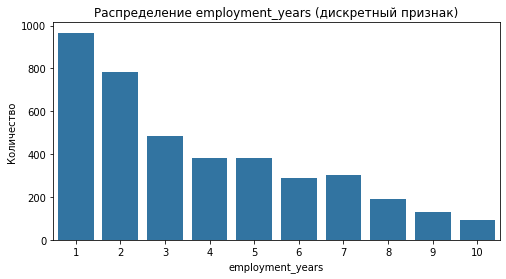

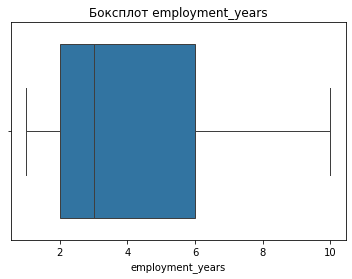

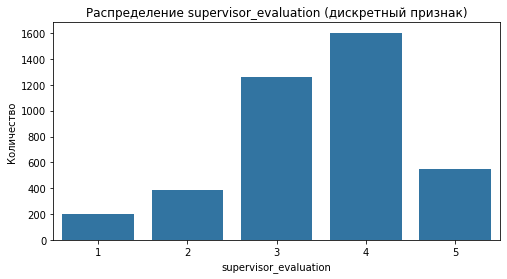

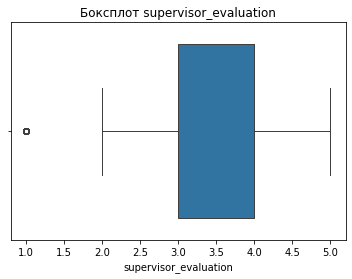

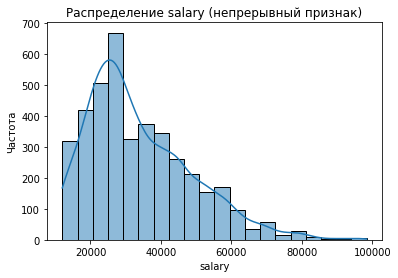

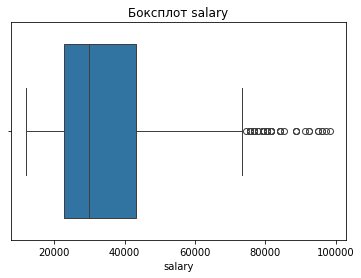

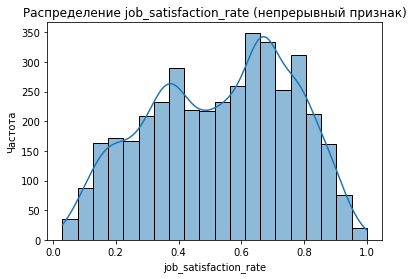

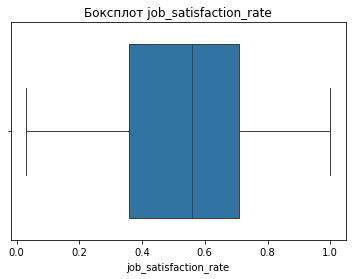

In [ ]:
grafic(train_job_satisfaction_rate)

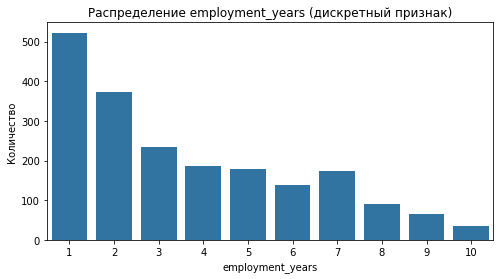

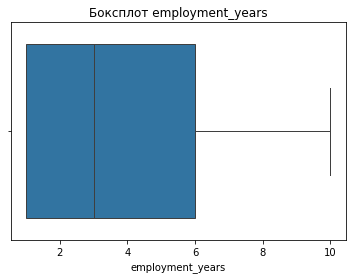

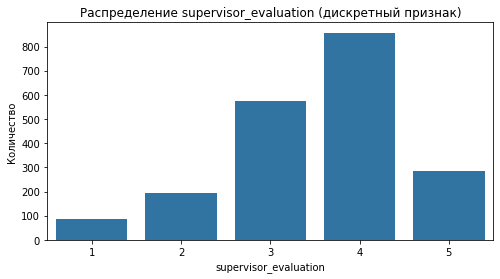

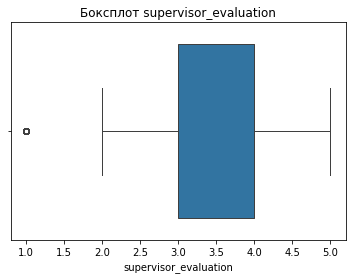

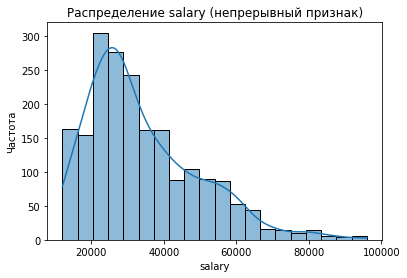

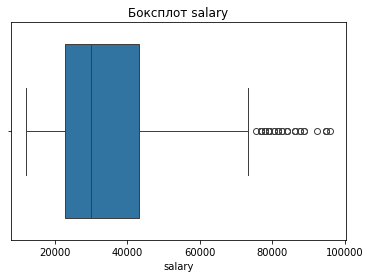

In [ ]:
grafic(test_features)

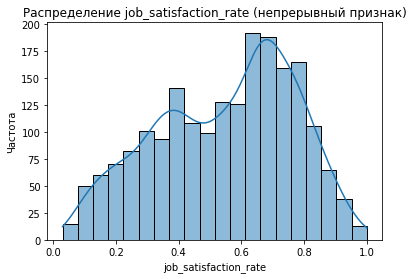

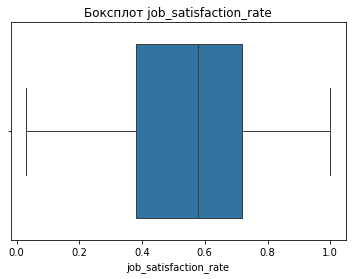

In [ ]:
grafic(test_target_job_satisfaction_rate)

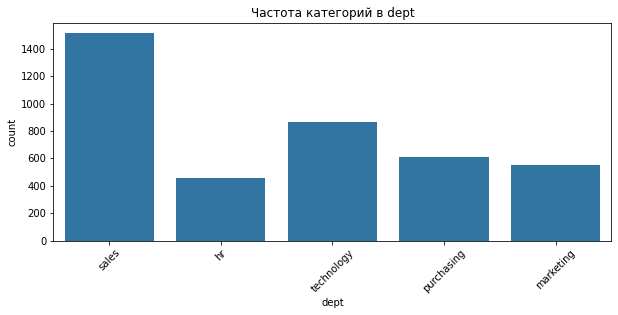

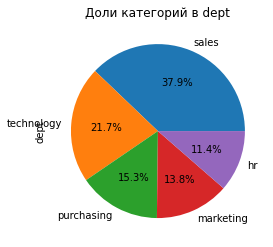

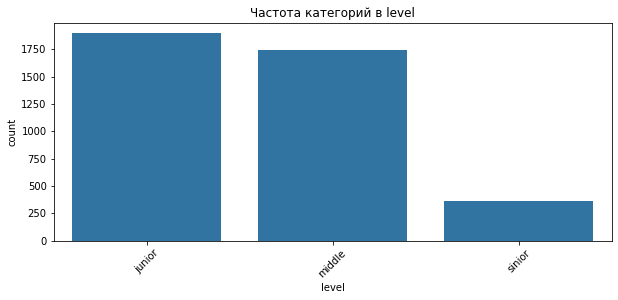

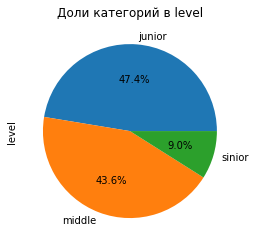

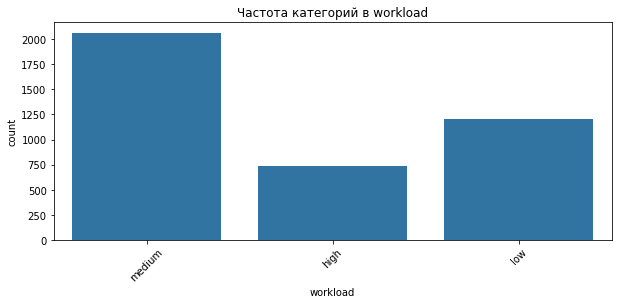

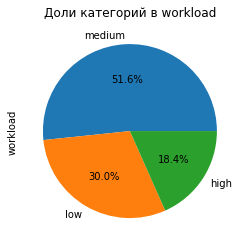

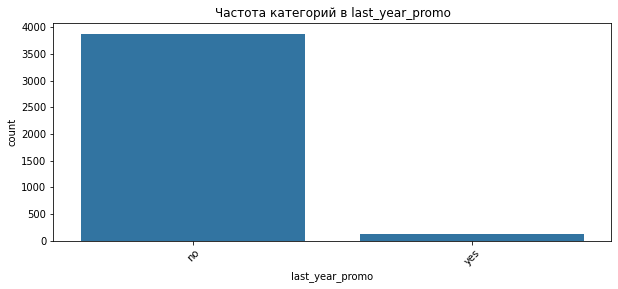

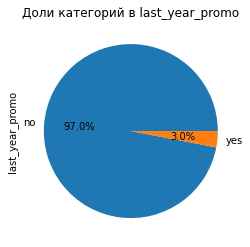

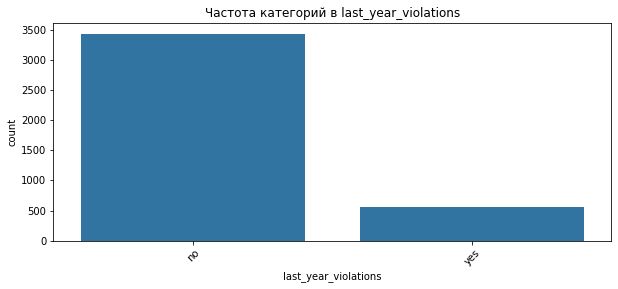

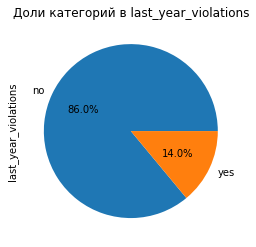

In [ ]:
grafic_categor(train_job_satisfaction_rate)

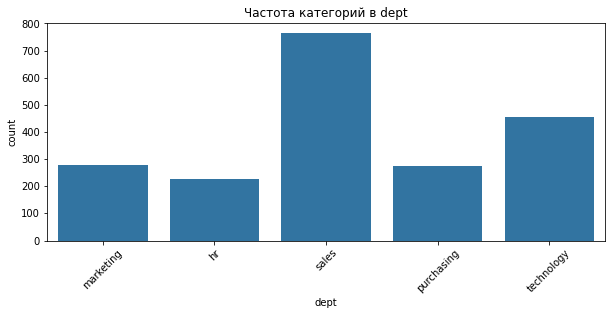

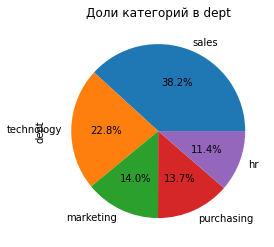

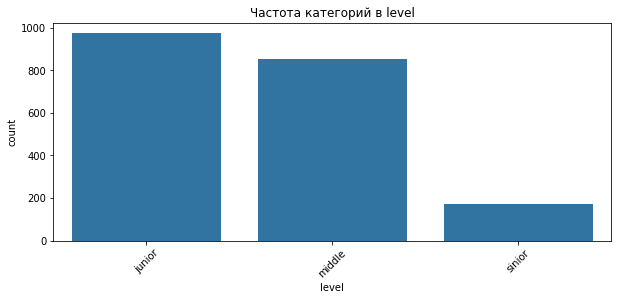

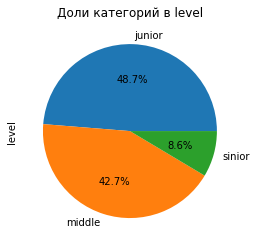

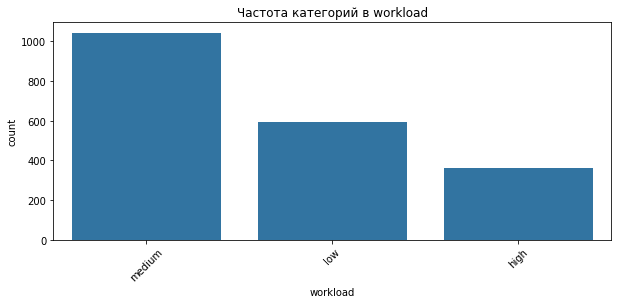

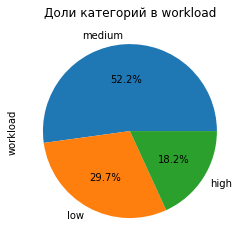

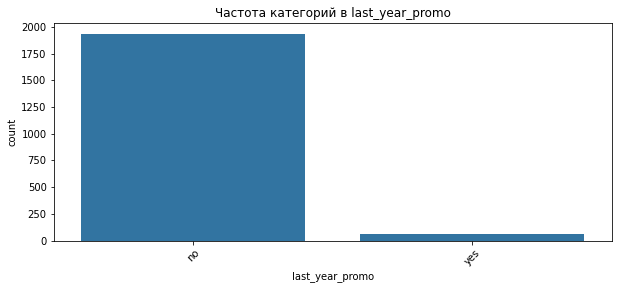

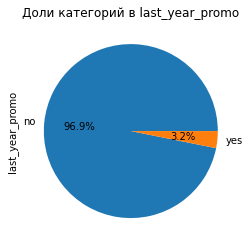

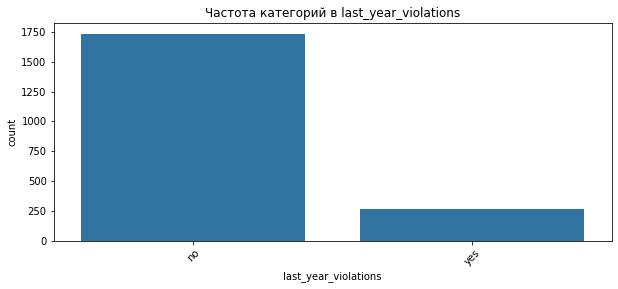

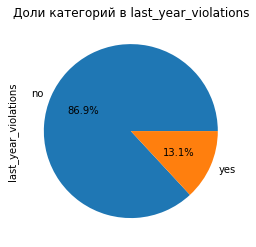

In [ ]:
grafic_categor(test_features)

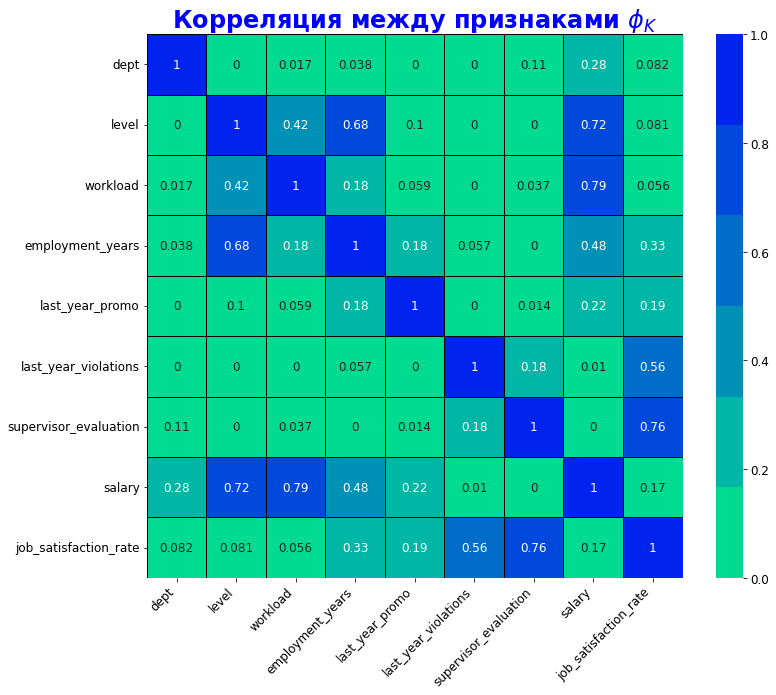

In [ ]:
file = train_job_satisfaction_rate[train_job_satisfaction_rate.columns[train_job_satisfaction_rate.columns != 'id']]

all_features = list(file.columns)

correlation = file[all_features].phik_matrix(interval_cols = [ 'salary', 'job_satisfaction_rate'])

plt.figure(figsize=(12,10))
colormap = sns.color_palette("winter_r")
plt.rc('font', size= 12)
chart = sns.heatmap(correlation, annot=True, cmap=colormap, linewidths=1, linecolor='black')
plt.title(r'Корреляция между признаками $\phi_K$', fontsize=24, fontweight="bold", color='blue')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_yticklabels(chart.get_xticklabels(), rotation=0, horizontalalignment='right')
plt.show()

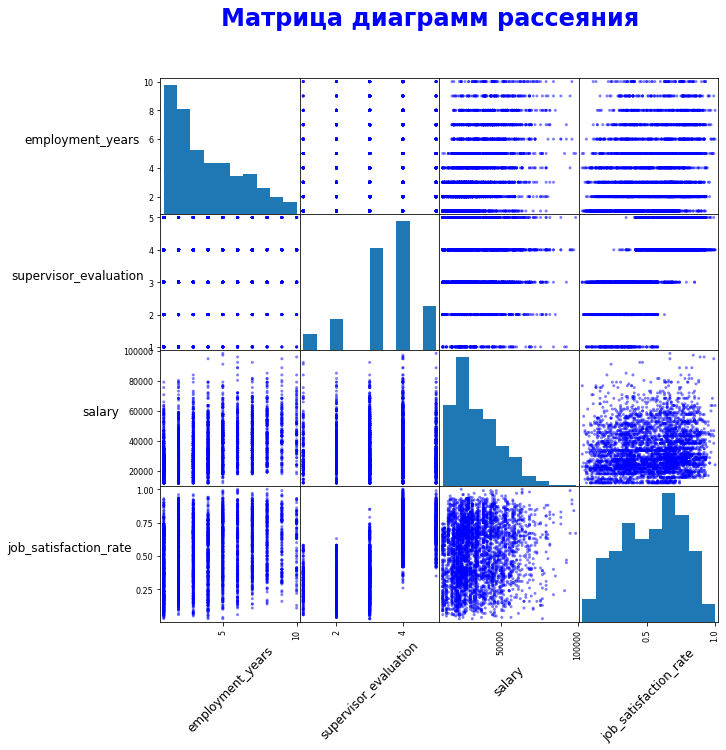

In [ ]:
file = train_job_satisfaction_rate

axes = pd.plotting.scatter_matrix(file[file.columns[file.columns != 'id']], figsize=(10, 10), color='blue')

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.suptitle('Матрица диаграмм рассеяния', fontsize=24, fontweight="bold", color='blue')
plt.show()

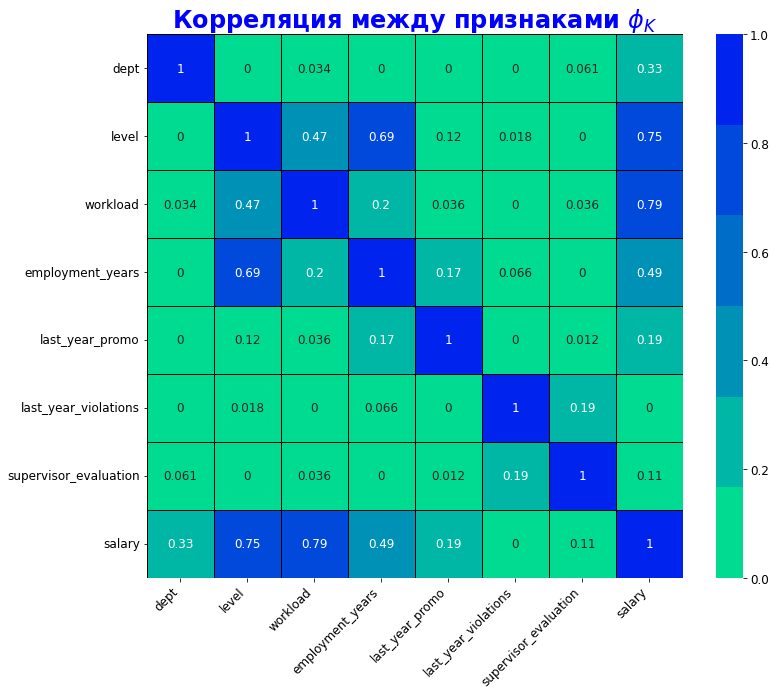

In [ ]:
file = test_features[test_features.columns[test_features.columns != 'id']]

all_features = list(file.columns)

correlation = file[all_features].phik_matrix(interval_cols = [ 'salary', 'job_satisfaction_rate'])

plt.figure(figsize=(12,10))
colormap = sns.color_palette("winter_r")
plt.rc('font', size= 12)
chart = sns.heatmap(correlation, annot=True, cmap=colormap, linewidths=1, linecolor='black')
plt.title(r'Корреляция между признаками $\phi_K$', fontsize=24, fontweight="bold", color='blue')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_yticklabels(chart.get_xticklabels(), rotation=0, horizontalalignment='right')
plt.show()

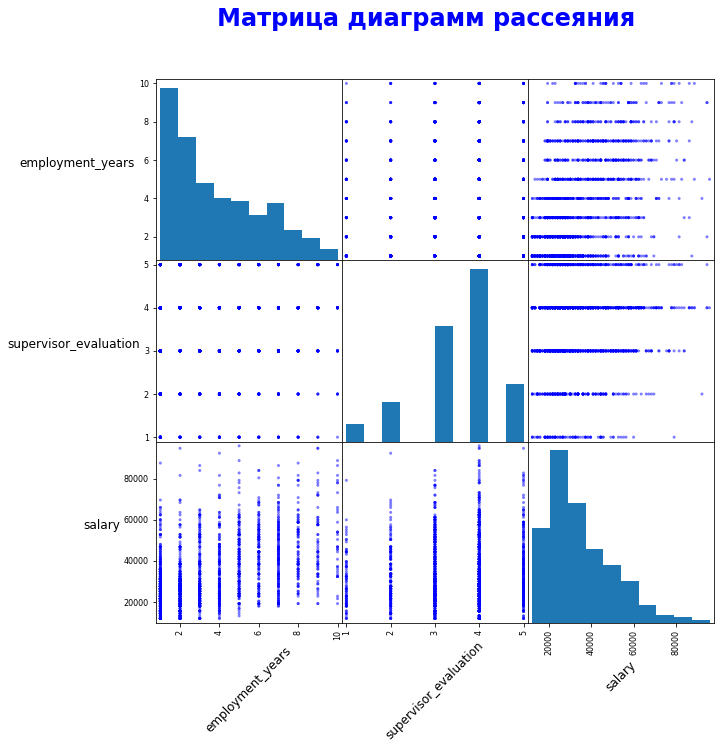

In [ ]:
file = test_features

axes = pd.plotting.scatter_matrix(file[file.columns[file.columns != 'id']], figsize=(10, 10), color='blue')

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.suptitle('Матрица диаграмм рассеяния', fontsize=24, fontweight="bold", color='blue')
plt.show()

Исследование показало наличие незначительного количества выбросов. Считаю это допустимым и удалять не будем. Остальных замечаний не выявлено.

## Подготовка данных

Перечислим особенности данных:

- Три признака:
    dept, last_year_promo, last_year_violations — нужно кодировать с помощью OneHotEncoder.

- Два признака: level, workload — нужно кодировать с помощью OrdinalEncoder.
    
- Количественных 3 признака:
   employment_years, supervisor_evaluation, salary - нужно масштабировать.

- В признаках пропуски встречаются и обработаем их в пайплайне.

- Целевой признак — job_satisfaction_rate. Задачу мультиклассовой классификации тут рассматривать не будем.

Так как мы удаляя признак id с неповторяющимися значениями получаем уменшение количества признаков. И могут появиться новые явные дубликаты: чем меньше признаков остаётся, тем выше шанс, что значения остальных признаков будут пересекаться. Проверим это и в дальнейшем удалим дубликаты.

In [ ]:
train_job_satisfaction_rate[train_job_satisfaction_rate.columns[train_job_satisfaction_rate.columns != 'id']].describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


In [ ]:
train_job_satisfaction_rate[train_job_satisfaction_rate.columns[train_job_satisfaction_rate.columns != 'id']].duplicated().sum()


245

In [ ]:
test_features[test_features.columns[test_features.columns != 'id']].describe()


,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


In [ ]:
test_target_job_satisfaction_rate[test_target_job_satisfaction_rate.columns[test_target_job_satisfaction_rate.columns != 'id']].describe()


,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


## Обучение моделей

In [ ]:
all_target_features = test_target_job_satisfaction_rate.merge(test_features, on='id', how='left')
display(all_target_features.head())
all_target_features[all_target_features.columns[all_target_features.columns != 'id']].describe()

,id,job_satisfaction_rate,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,130604,0.74,technology,junior,medium,1,no,no,4,34800
1,825977,0.75,marketing,middle,high,7,no,no,5,58800
2,418490,0.60,purchasing,junior,low,1,no,no,4,19200
3,555320,0.72,technology,junior,medium,1,no,no,4,34800
4,826430,0.08,technology,junior,medium,1,no,yes,2,30000


,job_satisfaction_rate,employment_years,supervisor_evaluation,salary
count,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.54878,3.666500,3.526500,34066.800000
std,0.22011,2.537222,0.996892,15398.436729
min,0.03000,1.000000,1.000000,12000.000000
25%,0.38000,1.000000,3.000000,22800.000000
50%,0.58000,3.000000,4.000000,30000.000000
75%,0.72000,6.000000,4.000000,43200.000000
max,1.00000,10.000000,5.000000,96000.000000


In [ ]:
train_1 = train_job_satisfaction_rate.drop(['id'], axis=1)
train_1.drop_duplicates(inplace=True)

test_1 = all_target_features.drop(['job_satisfaction_rate','id'], axis=1)

target_1 = all_target_features['job_satisfaction_rate']

In [ ]:
RANDOM_STATE = 100
TEST_SIZE = 0.25
X_train = train_1.drop('job_satisfaction_rate', axis=1)
y_train = train_1['job_satisfaction_rate']
X_test = test_1
y_test = target_1

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations'] #'
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),

    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid = [

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 15),
        'models__max_features': range(5, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

smape_scorer = make_scorer(score_func=smape, greater_is_better=False)

grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    n_jobs=-1,
    cv=5,
    scoring=smape_scorer
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(...
             param_grid=[{'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [DecisionTreeRegressor(random_state=100)],
                          'models__max_depth': range(5, 15),
                          'models__max_features': range(5, 15),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [ ]:
best_model = grid_search.best_estimator_
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_*(-1))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [ ]:
best_model = grid_search.best_estimator_
print(f'Метрика sMAPE лучшей модели по кросс-валидации на обучающих данных: {round(grid_search.best_score_*(-1),4)}')

Метрика sMAPE лучшей модели по кросс-валидации на обучающих данных: 15.7263


In [ ]:
print(f'Метрика sMAPE лучшей модели на тестовой выборке: {round(smape(y_test, best_model.predict(X_test)),4)}')

Метрика sMAPE лучшей модели на тестовой выборке: 14.5585


Mетрика SMAPE лучшей модели на тренировочной выборке составила: 14.5585

## Оформление выводов

Для поиска лучшей модели были предприняты следующие шаги:

- проведено исследование полученных даных и признаков
- в процессе поиска к данным применено 2 типа моделей классифкации
- на основе метрики SMAPE была отобрана лучшая модель ('models', DecisionTreeRegressor(max_depth=13, -    max_features=11, random_state=100) c использованием пайплайна
- метрика SMAPE лучшей модели на тренировочной выборке составила: 14.5585

# Задача 2

## Загрузка данных

In [ ]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
train_quit.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes
6,417070,technology,middle,medium,8,no,no,2,44400,no
7,165489,sales,middle,low,4,no,no,5,19200,no
8,996399,marketing,middle,low,7,no,no,4,25200,no
9,613206,technology,middle,medium,2,no,no,3,45600,yes


In [ ]:
test_features = pd.read_csv('/datasets/test_features.csv')
test_features.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


In [ ]:
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
test_target_quit.head(10)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no


## Предобработка данных

In [ ]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [ ]:
train_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [ ]:
train_quit.duplicated().sum()

0

In [ ]:
duplicate_id = train_quit[train_quit.duplicated(['id'])]

print(duplicate_id)

Empty DataFrame
Columns: [id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary, quit]
Index: []


In [ ]:
for col in train_quit.iloc[:, 1:8]:
    print(train_quit[col].unique ())

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
[ 2  5  1  8  4  7  3  9  6 10]
['no' 'yes']
['no' 'yes']
[4 1 3 5 2]


In [ ]:

test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [ ]:

test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [ ]:

test_features.duplicated().sum()

0

In [ ]:
duplicate_id = test_features[test_features.duplicated(['id'])]

print(duplicate_id)

Empty DataFrame
Columns: [id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary]
Index: []


In [ ]:
for col in test_features.iloc[:, 1:8]:
 print(test_features[col].unique ())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
[ 2  1  5  6  3  9  7  4  8 10]
['no' 'yes']
['no' 'yes']
[5 4 3 1 2]


In [ ]:

test_features['dept'] = test_features['dept'].replace(' ', np.nan)
test_features['workload'] = test_features['workload'].replace(' ', np.nan)
for col in test_features.iloc[:, 1:8]:
 print(test_features[col].unique ())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' nan]
[ 2  1  5  6  3  9  7  4  8 10]
['no' 'yes']
['no' 'yes']
[5 4 3 1 2]


In [ ]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [ ]:
test_target_quit.isna().sum()

id      0
quit    0
dtype: int64

In [ ]:

duplicate_id = test_target_quit[test_target_quit.duplicated(['id'])]

print(duplicate_id)

Empty DataFrame
Columns: [id, quit]
Index: []


Провели предобработку полученных данных. Дубликаты не обнаружены. Выявлены пропуски и пробелы в данных. Проведем замену пробелов ' ' на np.nan пропуск. Проведем в дальнейшем заполнение пропусков в пайплайне при обучении модели с использованием SimpleImputer в категориальных признаках на самое распростроненное значение.

## Исследовательский анализ данных

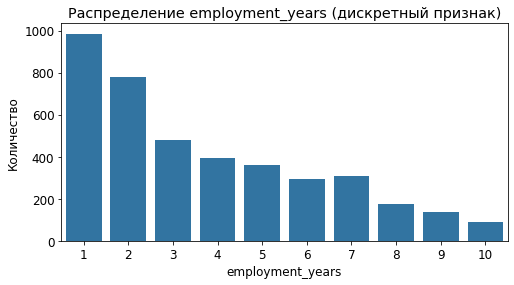

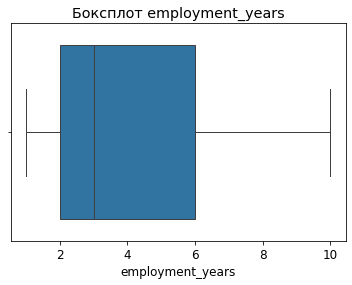

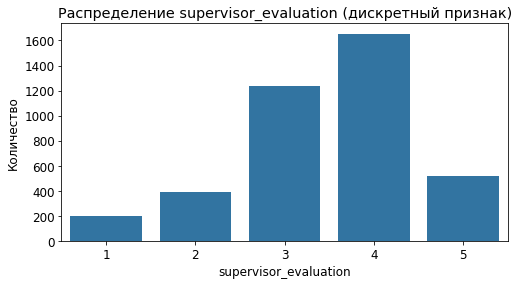

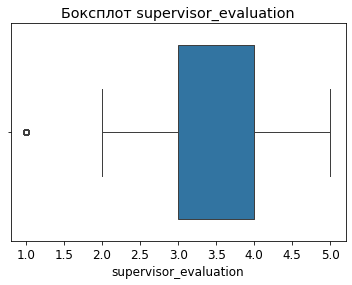

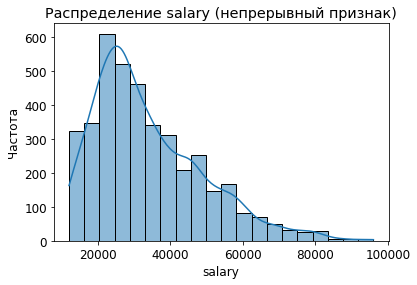

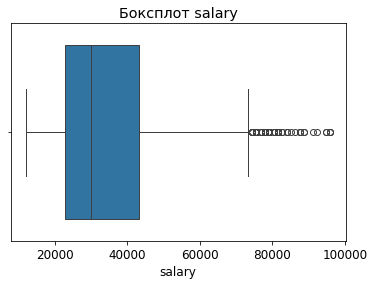

In [ ]:
grafic(train_quit)

In [ ]:
train_quit

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no
3996,672059,sales,middle,high,9,no,no,4,52800,no
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no


In [ ]:
file = train_quit[train_quit.columns[file.columns != 'id']]

all_features = list(file.columns)

correlation = file[all_features].phik_matrix(interval_cols = [ 'salary', 'job_satisfaction_rate'])

plt.figure(figsize=(12,10))
colormap = sns.color_palette("winter_r")
plt.rc('font', size= 12)
chart = sns.heatmap(correlation, annot=True, cmap=colormap, linewidths=1, linecolor='black')
plt.title(r'Корреляция между признаками $\phi_K$', fontsize=24, fontweight="bold", color='blue')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_yticklabels(chart.get_xticklabels(), rotation=0, horizontalalignment='right')
plt.show()

ValueError: Item wrong length 10 instead of 4000.

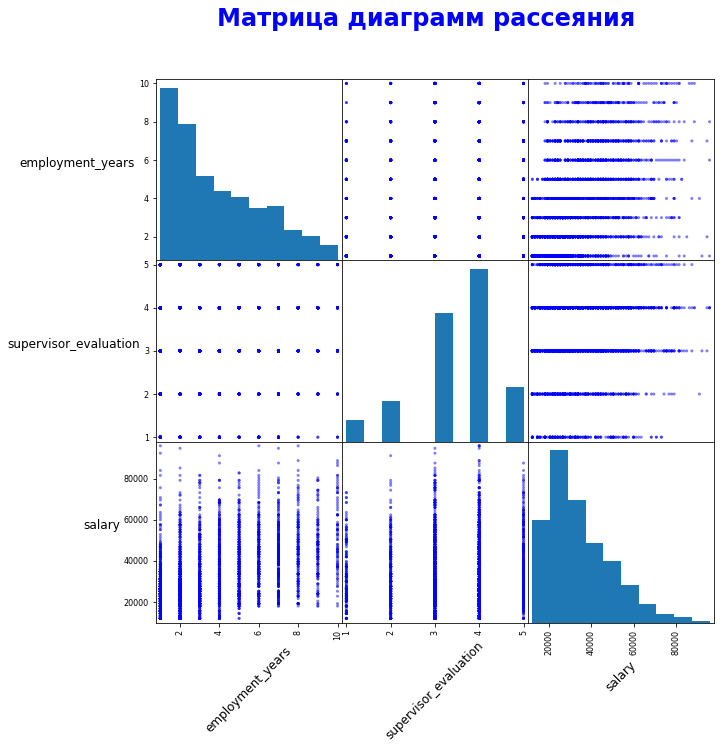

In [ ]:

file = train_quit

axes = pd.plotting.scatter_matrix(file[file.columns[file.columns != 'id']], figsize=(10, 10), color='blue')

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.suptitle('Матрица диаграмм рассеяния', fontsize=24, fontweight="bold", color='blue')
plt.show()

Исследование показало наличие незначительного количества выбросов. Считаю это допустимым и удалять не будем. Остальных замечаний не выявлено.

In [ ]:
def diagram(file, column, title, xlabel, ylabel):
    all = len(file)
    file_groupby = file.groupby(column).size()/all
    file_groupby_sort = file_groupby.sort_values()
    mm = file_groupby_sort.plot(kind='barh', color='blue', figsize=(16,8))
    plt.title(f'{title}', fontsize=16, fontweight="bold", color='blue')
    plt.xlabel(f'{xlabel}', fontsize=16, fontweight="bold", color='blue')
    plt.ylabel(f'{ylabel}', fontsize=16, fontweight="bold", color='blue')

    percent = dict(file_groupby_sort)
    row = 0
    i = 0
    for row in percent:
        mm.text(percent[row]-0.09, i, str(round(percent[row]*100, 2)) + '%',
                      fontsize = 'large', fontweight='bold', color='white')
        i += 1
def bar_chart_target(file, target, column, title, xlabel, ylabel, A, B):

    ax = file[column][file[target] == A].plot(kind='hist', bins= 50, grid=False, color='red', figsize=(16,8), alpha=0.5)
    ax = file[column][file[target] == B].plot(kind='hist', bins= 50, grid=False, color='blue', figsize=(16,8), alpha=0.5)
    ax.set_xlabel(xlabel, fontsize=16, fontweight="bold", color='blue')
    ax.set_ylabel(ylabel, fontsize=16, fontweight="bold", color='blue')

None
def bar_chart(file, column, title, xlabel, ylabel, bins):

    ax = file[column].plot(kind='hist', bins=bins, grid=False, color='blue', figsize=(16,8))
    ax.set_xlabel(xlabel, fontsize=16, fontweight="bold", color='blue')
    ax.set_ylabel(ylabel, fontsize=16, fontweight="bold", color='blue')

None

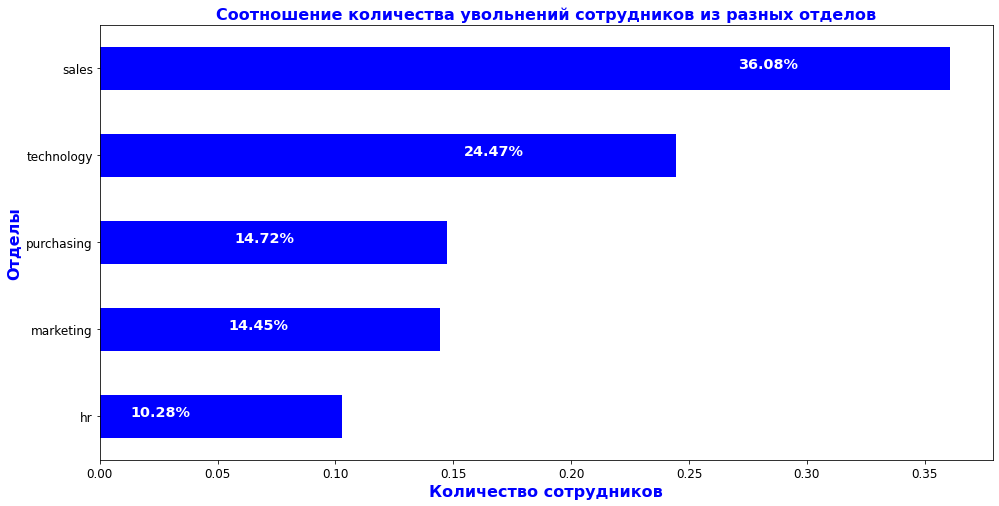

In [ ]:
file=train_quit[train_quit['quit'] == 'yes']
column='dept'
title='Соотношение количества увольнений сотрудников из разных отделов'
xlabel='Количество сотрудников'
ylabel='Отделы'
diagram(file, column, title, xlabel, ylabel)

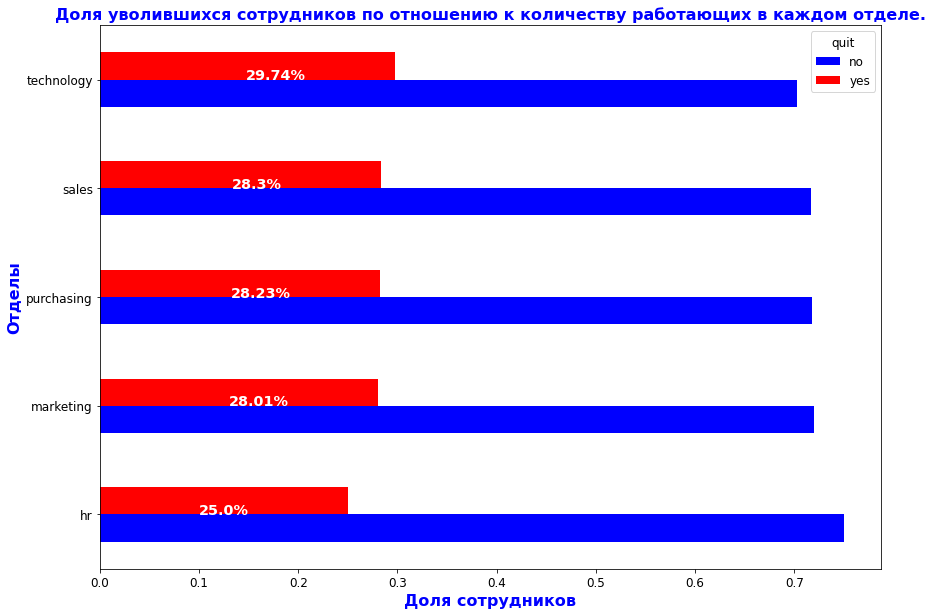

In [ ]:
file_groupby = train_quit.groupby(['dept'])['quit'].value_counts(normalize=True)

file_groupby_sort = file_groupby.sort_values()
mm = file_groupby_sort.unstack().plot(kind='barh', figsize=(14,10), color=['blue', 'red'])
plt.title('Доля уволившихся сотрудников по отношению к количеству работающих в каждом отделе.', fontsize=16, fontweight="bold", color='blue')
plt.xlabel('Доля сотрудников', fontsize=16, fontweight="bold", color='blue')
plt.ylabel('Отделы', fontsize=16, fontweight="bold", color='blue')

percent = dict(file_groupby_sort)
row = 0
i = 0
for row in percent:
    if percent[row] < 0.5:
        mm.text(percent[row]-0.15, i, str(round(percent[row]*100, 2)) + '%',
                  fontsize = 'large', fontweight='bold', color='white')
    i += 1

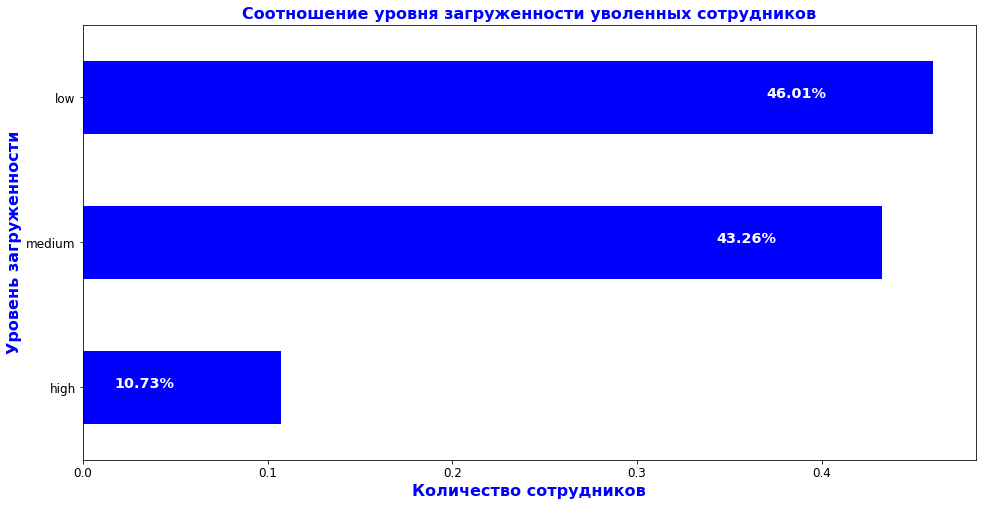

In [ ]:
file=train_quit[train_quit['quit'] == 'yes']
column='workload'
title='Соотношение уровня загруженности уволенных сотрудников'
xlabel='Количество сотрудников'
ylabel='Уровень загруженности'
diagram(file, column, title, xlabel, ylabel)

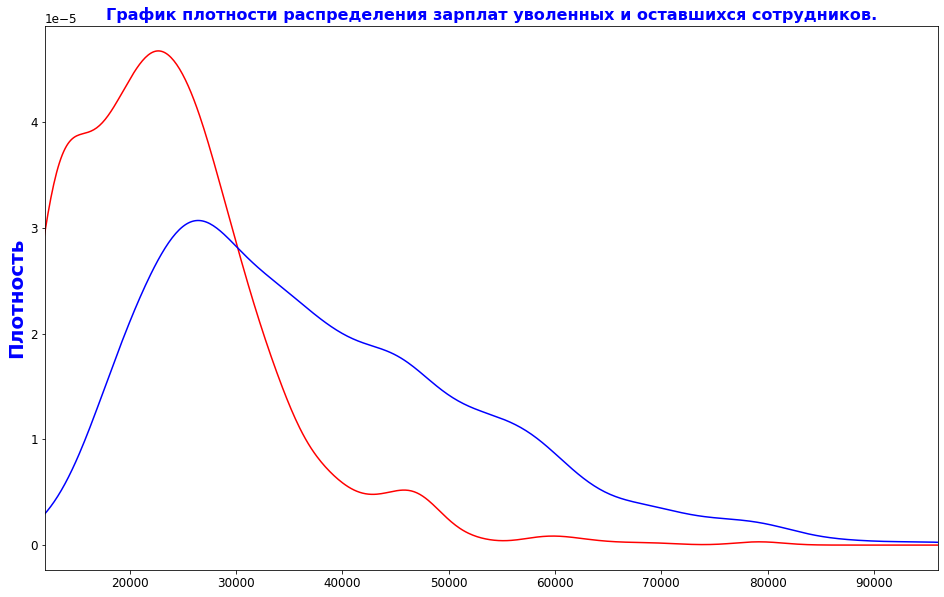

In [ ]:
plt.figure(figsize=(16,10))
plt.title('График плотности распределения зарплат уволенных и оставшихся сотрудников.', fontsize=16, fontweight="bold", color='blue')
plt.xlim (train_quit['salary'].min(), train_quit['salary'].max())
ax = train_quit['salary'][train_quit['quit'] == 'yes'].plot.kde(color='red')
ax = train_quit['salary'][train_quit['quit'] == 'no'].plot.kde(color='blue')
ax.set_ylabel('Плотность', fontsize=20, fontweight="bold", color='blue')

None

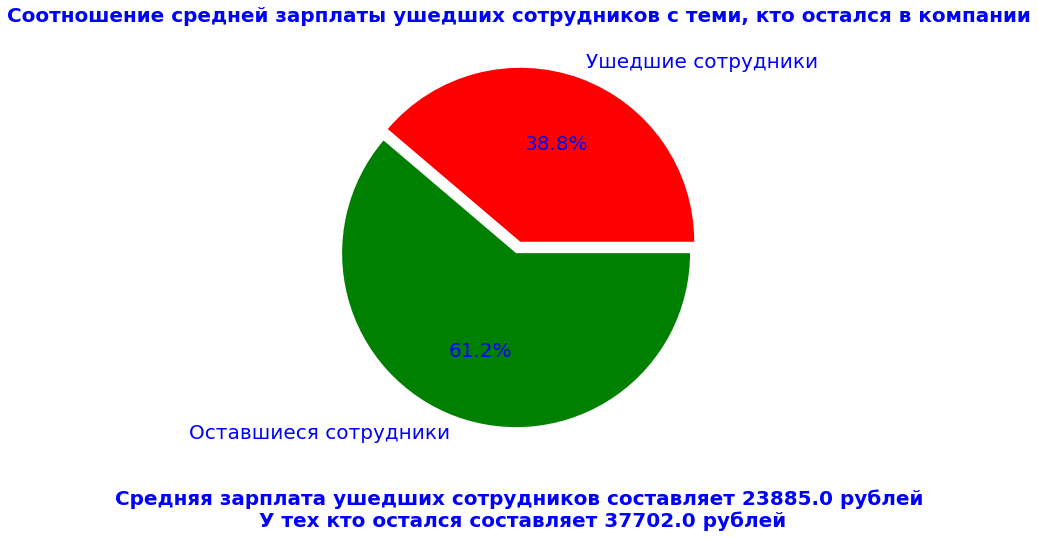

In [ ]:
gone = train_quit['salary'][train_quit['quit'] == 'yes'].mean()
remained = train_quit['salary'][train_quit['quit'] == 'no'].mean()
data = [gone, remained]
labels = ['Ушедшие сотрудники', 'Оставшиеся сотрудники']
plt.figure(figsize=(8,8))
plt.rc('font', size= 20 )

fbcolor = ["red", "green"]

explode = [0.02, 0.05]

plt.pie(data, labels = labels, explode = explode, colors = fbcolor, autopct='%.1f%%', textprops={'color':'b'})
plt.title('Соотношение средней зарплаты ушедших сотрудников с теми, кто остался в компании',
          fontsize=20, fontweight="bold", color='blue')
plt.xlabel(f'\nСредняя зарплата ушедших сотрудников составляет {round(gone,0)} рублей\n У тех кто остался составляет {round(remained,0)} рублей', fontsize=20, fontweight="bold", color='blue')
plt.show()

## Добавление нового входного признака

In [ ]:
train_quit['job_satisfaction_rate'] = best_model.predict(train_quit)

In [ ]:
train_quit.sort_values(by = 'id', ascending = True)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
2600,100222,sales,junior,medium,3,no,no,2,20400,yes,0.340000
717,100459,purchasing,junior,medium,3,no,no,3,21600,yes,0.333333
2455,100469,marketing,junior,medium,1,no,no,4,28800,no,0.664000
1592,100601,technology,middle,high,4,no,no,4,68400,no,0.660000
2657,100858,sales,junior,medium,2,no,no,4,25200,yes,0.838750
...,...,...,...,...,...,...,...,...,...,...,...
2194,998517,purchasing,middle,low,5,no,no,3,19200,no,0.470000
3701,999003,hr,middle,low,3,no,no,2,24000,yes,0.170000
3364,999158,purchasing,junior,medium,1,no,yes,1,21600,yes,0.090000
18,999835,sales,junior,low,5,no,no,4,18000,no,0.865000


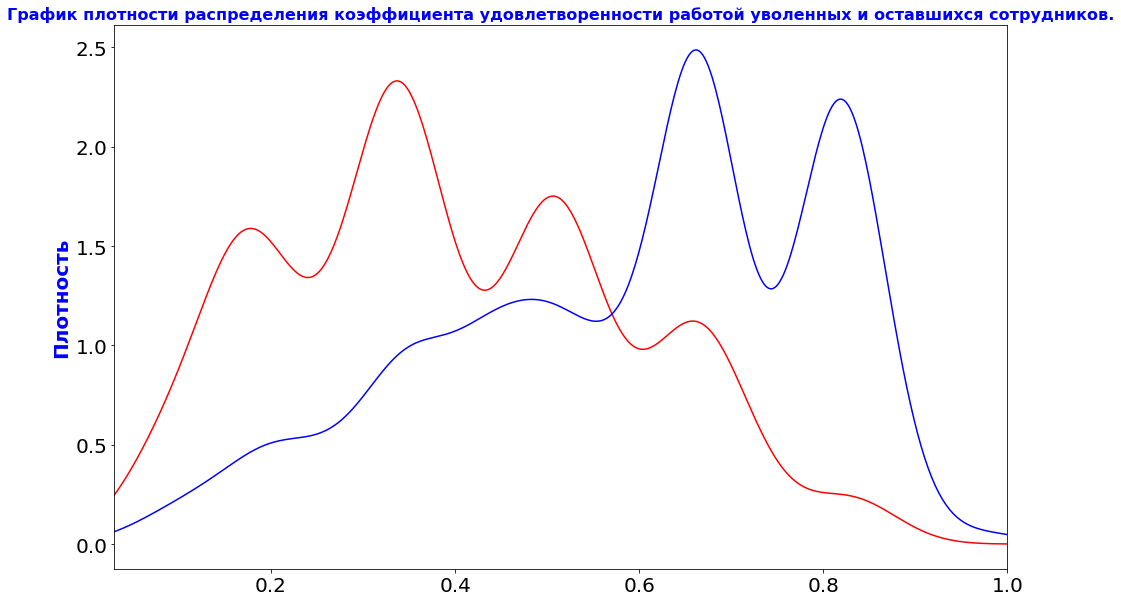

In [ ]:
plt.figure(figsize=(16,10))
plt.title('График плотности распределения коэффициента удовлетворенности работой уволенных и оставшихся сотрудников.', fontsize=16, fontweight="bold", color='blue')
plt.xlim (train_quit['job_satisfaction_rate'].min(), train_quit['job_satisfaction_rate'].max())
ax = train_quit['job_satisfaction_rate'][train_quit['quit'] == 'yes'].plot.kde(color='red')
ax = train_quit['job_satisfaction_rate'][train_quit['quit'] == 'no'].plot.kde(color='blue')
ax.set_ylabel('Плотность', fontsize=20, fontweight="bold", color='blue')

None

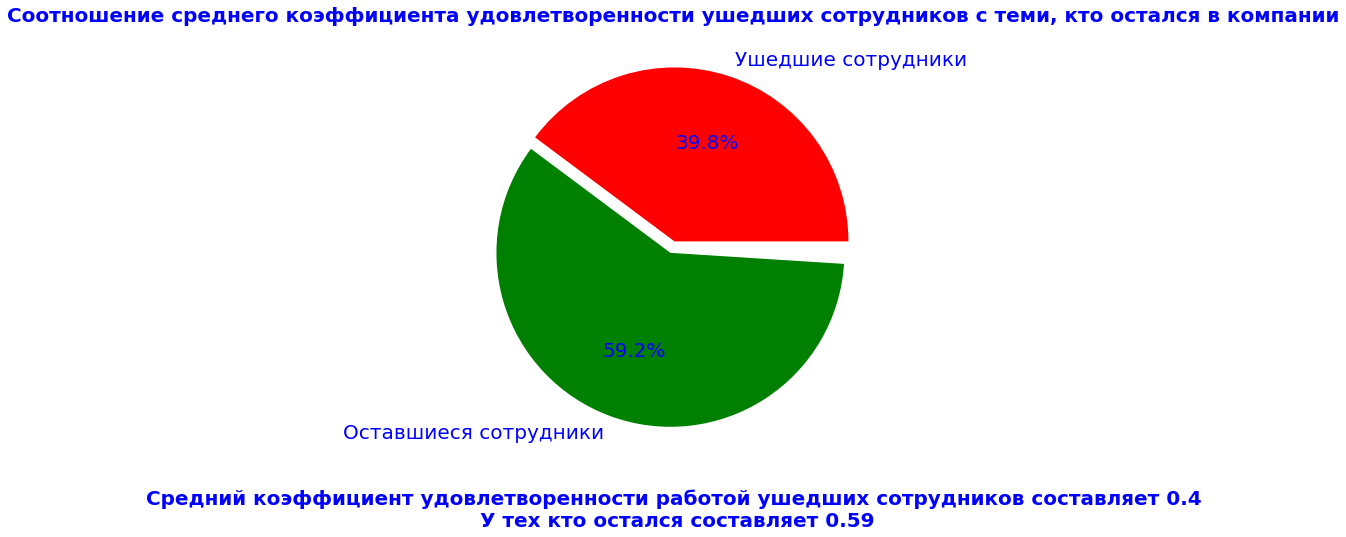

In [ ]:
gone = train_quit['job_satisfaction_rate'][train_quit['quit'] == 'yes'].mean()
remained = train_quit['job_satisfaction_rate'][train_quit['quit'] == 'no'].mean()
data = [gone, remained]
labels = ['Ушедшие сотрудники', 'Оставшиеся сотрудники']
plt.figure(figsize=(8,8))
plt.rc('font', size= 20 )

fbcolor = ["red", "green"]

explode = [0.02, 0.05]

plt.pie(data, labels = labels, explode = explode, colors = fbcolor, autopct='%.1f%%', textprops={'color':'b'}, normalize=False)
plt.title('Соотношение среднего коэффициента удовлетворенности ушедших сотрудников с теми, кто остался в компании', fontsize=20, fontweight="bold", color='blue')
plt.xlabel(f'\nСредний коэффициент удовлетворенности работой ушедших сотрудников составляет {round(gone,2)}\n У тех кто остался составляет {round(remained,2)}', fontsize=20, fontweight="bold", color='blue')
plt.show()

Исследования показало связь уровеня удовлетворённости сотрудника работой в компании на его решение об увольнении.

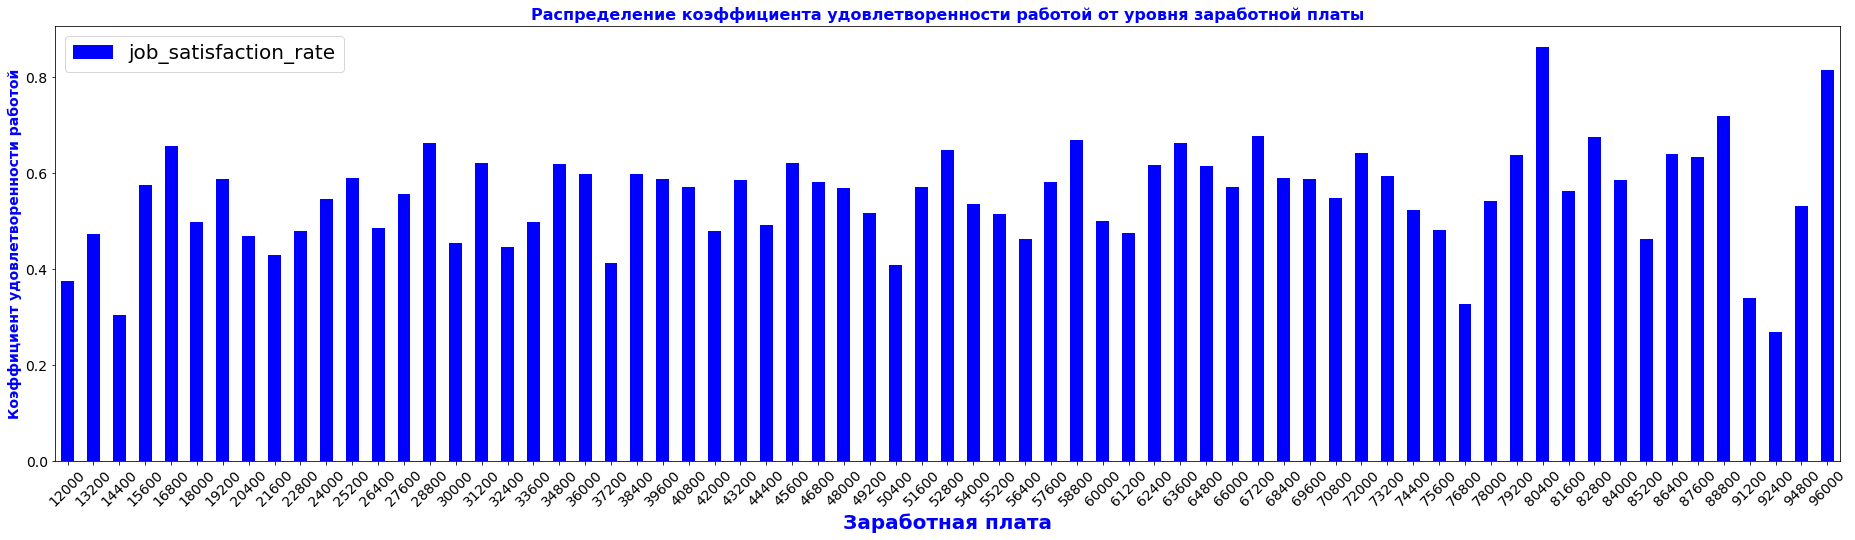

In [ ]:
satisfaction_salary = train_quit.pivot_table(index = 'salary', values = 'job_satisfaction_rate', aggfunc='mean')
satisfaction_salary.columns = ['job_satisfaction_rate']
satisfaction_salary = satisfaction_salary.sort_values('salary', ascending = True)
satisfaction_salary.plot(kind='bar', figsize=(32, 8), fontsize=14, color='blue', rot=45)
plt.title('Распределение коэффициента удовлетворенности работой от уровня заработной платы', fontsize=16, fontweight="bold", color='blue')
plt.ylabel('Коэффициент удовлетворенности работой', fontsize=14, fontweight="bold", color='blue')
plt.xlabel('Заработная плата', fontsize=20, fontweight="bold", color='blue')
plt.show()

Подмечено, что уровень заработной платы не влияет на коэффициент удовлетворенности работой сотрудника.

## Подготовка данных

Перечислим особенности данных:

- Три признака:
   dept, last_year_promo, last_year_violations — нужно кодировать с помощью OneHotEncoder.
- Два признака: level, workload — нужно кодировать с помощью OrdinalEncoder.
- Количественных 4 признака:
   employment_years, supervisor_evaluation, salary, job_satisfaction_rate - нужно масштабировать.
- В признаках пропуски встречаются и обработаем их в пайплайне.
- Целевой признак — quit. Задачу мультиклассовой классификации тут рассматривать не будем.

In [ ]:
train_quit[train_quit.columns[train_quit.columns != 'id']].describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000,0.537214
std,2.541852,1.004049,15152.415163,0.218353
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.350000
50%,3.000000,4.000000,30000.000000,0.550000
75%,6.000000,4.000000,43200.000000,0.688667
max,10.000000,5.000000,96000.000000,1.000000


In [ ]:
train_quit[train_quit.columns[train_quit.columns != 'id']].duplicated().sum()

1413

In [ ]:
test_features['job_satisfaction_rate'] = best_model.predict(test_features)
test_features[test_features.columns[test_features.columns != 'id']].describe()
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.863333
1,686555,hr,junior,medium,1,no,no,4,30000,0.670417
2,467458,sales,middle,low,5,no,no,4,19200,0.654000
3,418655,sales,middle,low,6,no,no,4,19200,0.655000
4,789145,hr,middle,medium,5,no,no,5,40800,0.824643


In [ ]:
test_target_quit[test_target_quit.columns[test_target_quit.columns != 'id']].describe()

,quit
count,2000
unique,2
top,no
freq,1436


## Обучение моделей

In [ ]:
all_target_features = test_target_quit.merge(test_features, on='id', how='left')
display(all_target_features.head())
all_target_features[all_target_features.columns[all_target_features.columns != 'id']].describe()

,id,quit,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,999029,yes,technology,junior,medium,1,no,no,3,31200,0.335
1,372846,no,sales,middle,medium,10,no,yes,2,32400,0.220
2,726767,no,marketing,middle,low,7,no,no,4,20400,0.670
3,490105,no,purchasing,middle,low,7,no,no,4,19200,0.695
4,416898,yes,purchasing,junior,low,1,no,no,4,12000,0.510


,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000,0.550391
std,2.537222,0.996892,15398.436729,0.217116
min,1.000000,1.000000,12000.000000,0.030000
25%,1.000000,3.000000,22800.000000,0.365000
50%,3.000000,4.000000,30000.000000,0.580923
75%,6.000000,4.000000,43200.000000,0.700625
max,10.000000,5.000000,96000.000000,0.990000


In [ ]:
train_quit['quit'] = train_quit['quit'].apply(lambda x: 1 if x =='yes' else 0)
train_2 = train_quit.drop(['id'], axis=1)
train_2.drop_duplicates(inplace=True)

test_2 = all_target_features.drop(['quit','id'], axis=1)

target_2 = all_target_features['quit']

In [ ]:
RANDOM_STATE = 100
TEST_SIZE = 0.25

X_train = train_2.drop('quit', axis=1)
y_train = train_2['quit']
X_test = test_2
y_test = target_2

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier())
])

param_grid = [

    {
        'models': [RandomForestClassifier()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 15),
        'models__max_features': range(5, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(10, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(...
                                                'passthrough']},
                         {'models': [DecisionTreeClassifier(random_state=100)],
                          'models__max_depth': range(5, 15),
                          'models__max_features': range(5, 15),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [KNeighborsClassifier()],
                          'models__n_neighbors': range(10, 20),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [ ]:
best_model = grid_search.best_estimator_
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print(f'Метрика ROC-AUC лучшей модели по кросс-валидации на обучающих данных: {round(grid_search.best_score_,4)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [ ]:
print(f'Метрика ROC-AUC лучшей модели на тестовой выборке: {round(roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1]),4)}')

Метрика ROC-AUC лучшей модели на тестовой выборке: 0.9121


На основе метрики ROC-AUC была отобрана лучшая модель ('models', KNeighborsClassifier(n_neighbors=17)). Получена метрика ROC-AUC на тестовой выборке со значением 0.9121. Что удовлетворяет требованию поиска не менее 0.91. Было подобрано для решения задачи RANDOM_STATE = 100

## Выводы

Для поиска лучшей модели, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика предприняты шаги:

- проведено исследование полученных данных и признаков
- необходимо было построить модель с метрикой SMAPE не более 15 на тестовой выборке
- в процессе поиска к данным применено 2 типа моделей классификации
- на основе метрики SMAPE была отобрана лучшая модель ('models', DecisionTreeRegressor(max_depth=11, max_features=12, random_state=120)) c использованием пайплайна
- метрика SMAPE лучшей модели на тренировочной выборке составила: 14.5585


Для поиска лучшей модели, которая сможет предсказать на основе данных заказчика, что сотрудник уволится из компании предприняты шаги:

- поставлена задача — построить модель, которая сможет на основе данных заказчика предсказать увольнение сотрудника из компании
- необходимо было построить модель с метрикой ROC-AUCне менее 0.91
- на основе метрики ROC-AUCбыла отобрана лучшая модель ('models', KNeighborsClassifier(n_neighbors=17))
- в процессе решения задачи и подбора параметров получено значение метрики ROC-AUC лучшей модели на тестовой выборке: 0.9121
- подобрано значение RANDOM_STATE = 100